In [1]:
# import necessary libraries    
import os
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# set path
RAW_DATA_DIR = '../data/raw/data_0506'
PROCESSED_DATA_DIR = '../data/processed'
IMAGE_SIZE = (224, 224)  # ResNet standard input size

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

In [6]:
# check the directories in the dataset  
print("Directories in the dataset:")
for dir_name in os.listdir(RAW_DATA_DIR):
    dir_path = os.path.join(RAW_DATA_DIR, dir_name)
    if os.path.isdir(dir_path):
        num_files = len(os.listdir(dir_path))
        print(f"{dir_name}: {num_files} files")

# Check image files in the ft1 directory
ft1_files = glob.glob(os.path.join(RAW_DATA_DIR, 'ft1', '*.png'))
print(f"\nNumber of images in ft1 directory: {len(ft1_files)}")

# Check CSV files in the at1 directory
at1_files = glob.glob(os.path.join(RAW_DATA_DIR, 'at1', '*.csv'))
print(f"Number of CSV files in at1 directory: {len(at1_files)}")

# Check the matching situation between image files and CSV files
ft1_frames = set([os.path.splitext(os.path.basename(f))[0] for f in ft1_files])
at1_frames = set([os.path.splitext(os.path.basename(f))[0] for f in at1_files])
common_frames = ft1_frames.intersection(at1_frames)

print(f"\nNumber of frames present in both ft1 and at1: {len(common_frames)}")
print(f"Number of frames only in ft1: {len(ft1_frames - common_frames)}")
print(f"Number of frames only in at1: {len(at1_frames - common_frames)}")

Directories in the dataset:
at1: 105 files
at1_to_at2: 105 files
at2: 105 files
ft1: 105 files
ft2: 105 files

Number of images in ft1 directory: 105
Number of CSV files in at1 directory: 105

Number of frames present in both ft1 and at1: 105
Number of frames only in ft1: 0
Number of frames only in at1: 0


## 1. 探索並配對數據集

我們需要從以下目錄中配對數據：
- `ft1`: t1 時刻的超聲波圖像
- `at1`: t1 時刻的 6-DOF 動作 (絕對值)
- `at1_to_at2`: 從 t1 到 t2 的 6-DOF 動作變化
- `ft2`: t2 時刻的超聲波圖像
- `at2`: t2 時刻的 6-DOF 動作 (絕對值)

我們將以 `at1_to_at2` 中的文件為基準，來尋找對應的 `t1` 和 `t2` 數據。

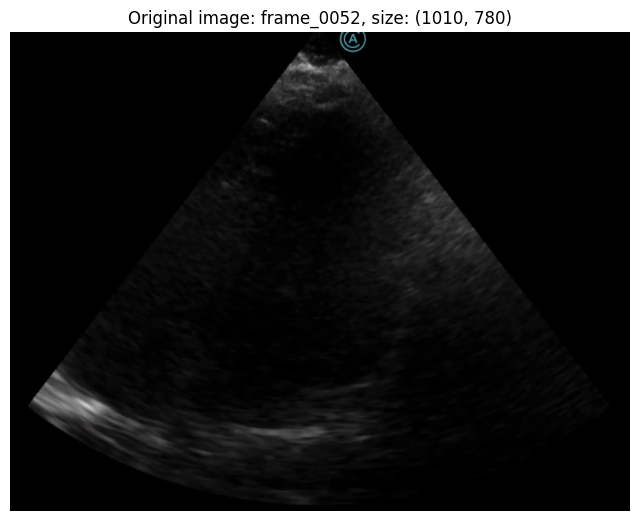

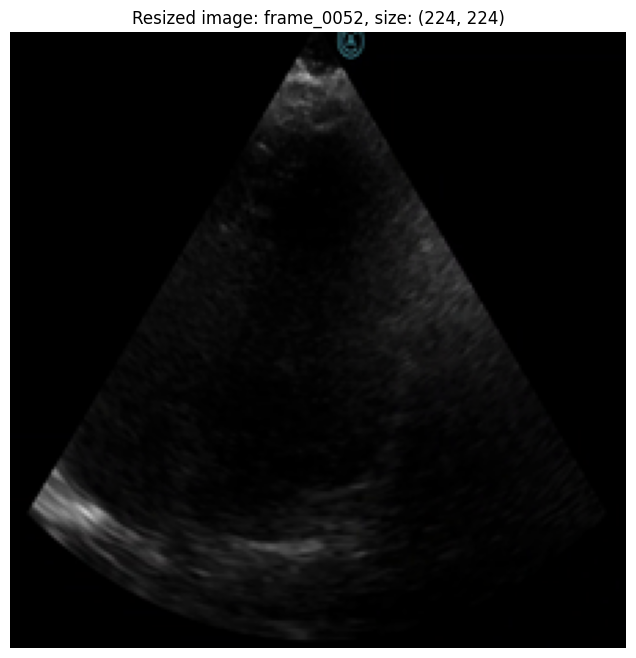


Motion data (6-DOF) for frame_0052:
     X (mm)     Y (mm)    Z (mm)  Roll (deg)  Pitch (deg)  Yaw (deg)
0  4.755612  57.397834 -10.31995  -13.930308    10.744573 -15.626257


In [7]:
# Selecting a sample frame for inspection
sample_frame = list(common_frames)[0]
sample_img_path = os.path.join(RAW_DATA_DIR, 'ft1', f"{sample_frame}.png")
sample_csv_path = os.path.join(RAW_DATA_DIR, 'at1', f"{sample_frame}.csv")

# Display the image
img = Image.open(sample_img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title(f"Original image: {sample_frame}, size: {img.size}")
plt.axis('off')
plt.show()

# Display the resized image (224x224)
img_resized = img.resize(IMAGE_SIZE, Image.LANCZOS)
plt.figure(figsize=(8, 8))
plt.imshow(img_resized, cmap='gray')
plt.title(f"Resized image: {sample_frame}, size: {img_resized.size}")
plt.axis('off')
plt.show()

# Display CSV data
csv_data = pd.read_csv(sample_csv_path)
print(f"\nMotion data (6-DOF) for {sample_frame}:")
print(csv_data)

## 3. Processing the Data

Now we will process all common frames, resize images to 224×224, and organize motion data.

In [9]:
import os
import glob
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np # 確保導入 numpy

# RAW_DATA_DIR 和 IMAGE_SIZE 應已在之前的程式碼區塊中定義
# PROCESSED_DATA_DIR 也應已定義

# 創建處理後數據的目錄結構
processed_images_ft1_dir = os.path.join(PROCESSED_DATA_DIR, 'images_ft1')
processed_images_ft2_dir = os.path.join(PROCESSED_DATA_DIR, 'images_ft2')
processed_actions_dir = os.path.join(PROCESSED_DATA_DIR, 'actions_transitions') # 更改目錄名以反映內容

os.makedirs(processed_images_ft1_dir, exist_ok=True)
os.makedirs(processed_images_ft2_dir, exist_ok=True)
os.makedirs(processed_actions_dir, exist_ok=True)

# 獲取 at1_to_at2 目錄中的所有轉換 CSV 文件
transition_files = glob.glob(os.path.join(RAW_DATA_DIR, 'at1_to_at2', '*.csv'))
print(f"找到 {len(transition_files)} 個轉換文件 (at1_to_at2)。")

all_valid_transitions = []

print("正在配對並處理有效的數據轉換...")
for trans_file_path in tqdm(transition_files):
    trans_file_name = os.path.basename(trans_file_path)
    parts = os.path.splitext(trans_file_name)[0].split('_to_')
    
    if len(parts) == 2 and parts[0].startswith('frame') and parts[1].startswith('frame'):
        frame_t1_name = parts[0] # e.g., "frame_0000"
        frame_t2_name = parts[1] # e.g., "frame_0007"
    else:
        print(f"警告：無法解析轉換文件名: {trans_file_name}")
        continue

    # 定義所有必要文件的路徑
    ft1_path = os.path.join(RAW_DATA_DIR, 'ft1', f"{frame_t1_name}.png")
    at1_path = os.path.join(RAW_DATA_DIR, 'at1', f"{frame_t1_name}.csv")
    
    ft2_path = os.path.join(RAW_DATA_DIR, 'ft2', f"{frame_t2_name}.png")
    at2_path = os.path.join(RAW_DATA_DIR, 'at2', f"{frame_t2_name}.csv")

    # 檢查所有文件是否存在
    if not all(os.path.exists(p) for p in [ft1_path, at1_path, ft2_path, at2_path, trans_file_path]):
        # print(f"缺少文件，跳過轉換: {frame_t1_name} -> {frame_t2_name}")
        continue

    try:
        # 處理圖像 ft1
        img_ft1 = Image.open(ft1_path)
        img_ft1_resized = img_ft1.resize(IMAGE_SIZE, Image.LANCZOS)
        processed_ft1_save_path = os.path.join(processed_images_ft1_dir, f"{frame_t1_name}.png")
        img_ft1_resized.save(processed_ft1_save_path)

        # 處理圖像 ft2
        img_ft2 = Image.open(ft2_path)
        img_ft2_resized = img_ft2.resize(IMAGE_SIZE, Image.LANCZOS)
        processed_ft2_save_path = os.path.join(processed_images_ft2_dir, f"{frame_t2_name}.png")
        img_ft2_resized.save(processed_ft2_save_path)

        # 讀取動作數據
        at1_data = pd.read_csv(at1_path).iloc[0] # 假設只有一行有效數據
        at1_to_at2_data = pd.read_csv(trans_file_path).iloc[0]
        at2_data = pd.read_csv(at2_path).iloc[0]

        transition_record = {
            'frame_t1': frame_t1_name,
            'frame_t2': frame_t2_name,
            'ft1_image_path': os.path.relpath(processed_ft1_save_path, PROCESSED_DATA_DIR),
            'ft2_image_path': os.path.relpath(processed_ft2_save_path, PROCESSED_DATA_DIR),
            
            'at1_X_mm': at1_data['X (mm)'],
            'at1_Y_mm': at1_data['Y (mm)'],
            'at1_Z_mm': at1_data['Z (mm)'],
            'at1_Roll_deg': at1_data['Roll (deg)'],
            'at1_Pitch_deg': at1_data['Pitch (deg)'],
            'at1_Yaw_deg': at1_data['Yaw (deg)'],
            
            'change_X_mm': at1_to_at2_data['X Change (mm)'],
            'change_Y_mm': at1_to_at2_data['Y Change (mm)'],
            'change_Z_mm': at1_to_at2_data['Z Change (mm)'],
            'change_Roll_deg': at1_to_at2_data['Roll Change (deg)'],
            'change_Pitch_deg': at1_to_at2_data['Pitch Change (deg)'],
            'change_Yaw_deg': at1_to_at2_data['Yaw Change (deg)'],

            'at2_X_mm': at2_data['X (mm)'],
            'at2_Y_mm': at2_data['Y (mm)'],
            'at2_Z_mm': at2_data['Z (mm)'],
            'at2_Roll_deg': at2_data['Roll (deg)'],
            'at2_Pitch_deg': at2_data['Pitch (deg)'],
            'at2_Yaw_deg': at2_data['Yaw (deg)'],
        }
        all_valid_transitions.append(transition_record)

    except Exception as e:
        print(f"處理轉換 {trans_file_name} 時發生錯誤: {e}")
        continue

# 將所有有效的轉換數據合併為一個 DataFrame 並保存
transitions_df = pd.DataFrame(all_valid_transitions)
output_csv_path = os.path.join(processed_actions_dir, 'all_transitions_data.csv')
transitions_df.to_csv(output_csv_path, index=False)

print(f"\n處理完成！共找到並處理了 {len(all_valid_transitions)} 組有效的數據轉換。")
print(f"調整大小的 ft1 圖像已保存到: {processed_images_ft1_dir}")
print(f"調整大小的 ft2 圖像已保存到: {processed_images_ft2_dir}")
print(f"所有轉換的動作數據已保存到: {output_csv_path}")

# 顯示一些樣本數據（可選）
if not transitions_df.empty:
    print("\n保存的轉換數據樣本：")
    print(transitions_df.head())
else:
    print("\n沒有有效的轉換數據被處理。")

找到 105 個轉換文件 (at1_to_at2)。
正在配對並處理有效的數據轉換...


100%|██████████| 105/105 [00:06<00:00, 16.62it/s]


處理完成！共找到並處理了 105 組有效的數據轉換。
調整大小的 ft1 圖像已保存到: ../data/processed\images_ft1
調整大小的 ft2 圖像已保存到: ../data/processed\images_ft2
所有轉換的動作數據已保存到: ../data/processed\actions_transitions\all_transitions_data.csv

保存的轉換數據樣本：
     frame_t1    frame_t2             ft1_image_path  \
0  frame_0000  frame_0007  images_ft1\frame_0000.png   
1  frame_0007  frame_0033  images_ft1\frame_0007.png   
2  frame_0033  frame_0045  images_ft1\frame_0033.png   
3  frame_0045  frame_0052  images_ft1\frame_0045.png   
4  frame_0052  frame_0058  images_ft1\frame_0052.png   

              ft2_image_path   at1_X_mm   at1_Y_mm   at1_Z_mm  at1_Roll_deg  \
0  images_ft2\frame_0007.png -13.613698  79.013052 -26.215955    -21.336408   
1  images_ft2\frame_0033.png -11.072683  73.473931 -21.275126    -19.900839   
2  images_ft2\frame_0045.png  -9.155552  68.659596 -17.114489    -18.890349   
3  images_ft2\frame_0052.png  -4.612398  63.857779 -13.485499    -18.579656   
4  images_ft2\frame_0058.png   4.755612  57.397834 -10.3

## 2. 創建訓練/驗證/測試集分割

我們將處理後的 `all_transitions_data.csv` 中的轉換數據集分割為訓練、驗證和測試集。
我們將使用 `frame_t1` 和 `frame_t2` 的組合作為唯一標識符。

In [10]:
# 從 all_transitions_data.csv 載入處理後的數據
processed_transitions_df = pd.read_csv(os.path.join(processed_actions_dir, 'all_transitions_data.csv'))

if not processed_transitions_df.empty:
    # 創建唯一標識符 (例如，結合 frame_t1 和 frame_t2)
    # 為了簡化，我們直接使用 DataFrame 的索引作為打亂對象
    transition_indices = list(processed_transitions_df.index)

    # 隨機打亂索引順序
    np.random.seed(42) # 固定隨機種子以確保可重複性
    np.random.shuffle(transition_indices)

    # 按 8:1:1 的比例分割為訓練、驗證和測試集
    train_ratio, val_ratio = 0.8, 0.1
    n_samples = len(transition_indices)
    n_train = int(n_samples * train_ratio)
    n_val = int(n_samples * val_ratio)

    train_indices = transition_indices[:n_train]
    val_indices = transition_indices[n_train:n_train+n_val]
    test_indices = transition_indices[n_train+n_val:]

    # 創建並保存分割索引文件 (這裡我們直接保存對應的 DataFrame 子集)
    # 或者，您可以保存索引列表到 .txt 文件，然後在加載時使用 .iloc[index_list]
    
    splits_data = {
        'train': processed_transitions_df.iloc[train_indices],
        'val': processed_transitions_df.iloc[val_indices],
        'test': processed_transitions_df.iloc[test_indices]
    }

    for split_name, df_split in splits_data.items():
        split_csv_path = os.path.join(PROCESSED_DATA_DIR, f"{split_name}_transitions.csv")
        df_split.to_csv(split_csv_path, index=False)
        print(f"{split_name} 集: {len(df_split)} 個轉換，已保存到 {split_csv_path}")
else:
    print("沒有轉換數據可供分割。")


train 集: 84 個轉換，已保存到 ../data/processed\train_transitions.csv
val 集: 10 個轉換，已保存到 ../data/processed\val_transitions.csv
test 集: 11 個轉換，已保存到 ../data/processed\test_transitions.csv


## 3. 創建適合模型訓練的數據格式 (NPZ 和 JSON)

現在我們將每個分割 (train, val, test) 的數據轉換為 NPZ 和 JSON 格式，方便模型加載。
每個樣本將包含：
- `frame_t1`, `frame_t2`
- `ft1_image_path`, `ft2_image_path` (相對於 PROCESSED_DATA_DIR)
- `at1` 的 6-DOF (作為一個列表或向量)
- `action_change` (從 t1 到 t2 的 6-DOF 變化，作為一個列表或向量)
- `at2` 的 6-DOF (作為一個列表或向量)

In [11]:
import json # 確保導入 json

def create_dataset_files_from_df(split_name, df_split):
    if df_split.empty:
        print(f"{split_name}集的 DataFrame 為空，跳過創建 NPZ/JSON 文件。")
        return 0
        
    dataset_list = []
    for index, row in df_split.iterrows():
        sample = {
            'frame_t1': row['frame_t1'],
            'frame_t2': row['frame_t2'],
            'ft1_image_path': row['ft1_image_path'], # 這些路徑已經是相對 PROCESSED_DATA_DIR 的
            'ft2_image_path': row['ft2_image_path'],
            
            'at1_6dof': [row['at1_X_mm'], row['at1_Y_mm'], row['at1_Z_mm'], 
                         row['at1_Roll_deg'], row['at1_Pitch_deg'], row['at1_Yaw_deg']],
            
            'action_change_6dof': [row['change_X_mm'], row['change_Y_mm'], row['change_Z_mm'],
                                   row['change_Roll_deg'], row['change_Pitch_deg'], row['change_Yaw_deg']],
            
            'at2_6dof': [row['at2_X_mm'], row['at2_Y_mm'], row['at2_Z_mm'],
                         row['at2_Roll_deg'], row['at2_Pitch_deg'], row['at2_Yaw_deg']],
        }
        dataset_list.append(sample)

    # 保存為 NPZ 文件
    # 注意：np.savez 需要將列表轉換為 numpy 數組才能高效儲存，或者直接儲存字典列表（但可能不是最優）
    # 為了簡單起見，這裡我們儲存字典列表。對於大型數據集，最好將每個字段轉換為numpy數組。
    npz_path = os.path.join(PROCESSED_DATA_DIR, f"{split_name}_transitions_dataset.npz")
    np.savez(npz_path, data=np.array(dataset_list, dtype=object)) # dtype=object 用於儲存字典列表

    # 保存為 JSON 文件
    json_path = os.path.join(PROCESSED_DATA_DIR, f"{split_name}_transitions_dataset.json")
    with open(json_path, 'w') as f:
        json.dump(dataset_list, f, indent=2)
        
    print(f"為 {split_name} 創建了 {len(dataset_list)} 個樣本的 NPZ 和 JSON 文件。")
    return len(dataset_list)

# 為每個分割創建數據集文件
if 'splits_data' in locals() and splits_data: # 檢查 splits_data 是否已定義且非空
    for split_name, df_split_data in splits_data.items():
        create_dataset_files_from_df(split_name, df_split_data)
else:
    print("沒有分割數據可供創建 NPZ/JSON 文件 (splits_data 未定義或為空)。")


為 train 創建了 84 個樣本的 NPZ 和 JSON 文件。
為 val 創建了 10 個樣本的 NPZ 和 JSON 文件。
為 test 創建了 11 個樣本的 NPZ 和 JSON 文件。


## 4. 驗證預處理後的數據

最後，我們加載一個分割的 JSON 文件，並顯示一些樣本以驗證數據是否正確。


Loaded 84 training samples from ../data/processed\train_transitions_dataset.json.


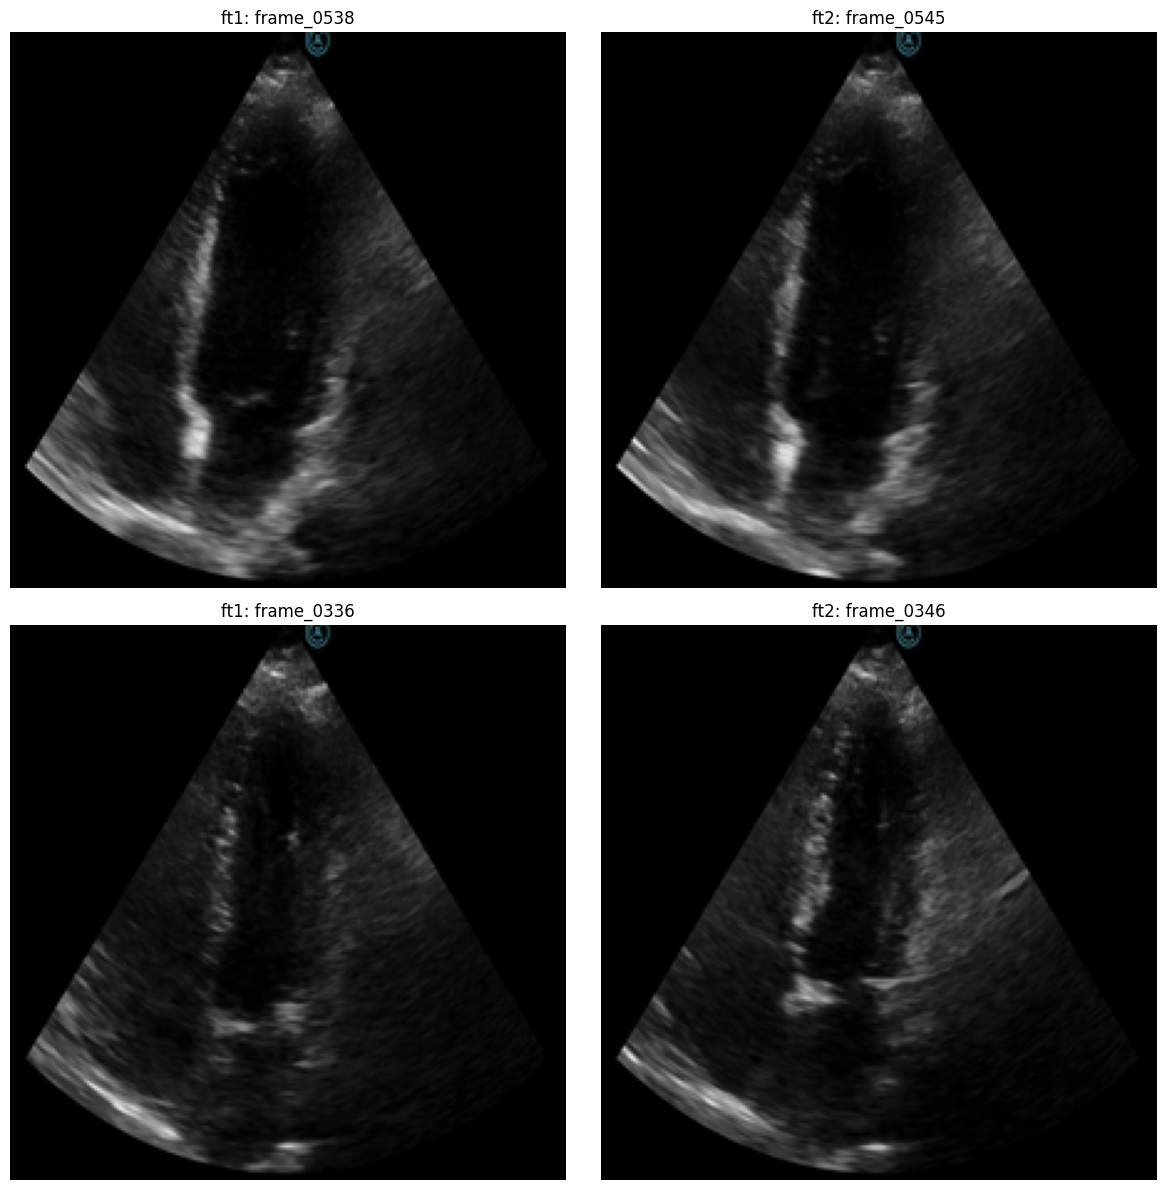


Preprocessing (including transition data) complete!


In [13]:
# Load and display some samples from the processed training set
import random # Ensure random is imported

# Try to load the training dataset (JSON)
train_dataset_json_path = os.path.join(PROCESSED_DATA_DIR, 'train_transitions_dataset.json')

if os.path.exists(train_dataset_json_path):
    with open(train_dataset_json_path, 'r') as f:
        train_transitions_data = json.load(f)

    if train_transitions_data: # Check if the list is empty
        print(f"\nLoaded {len(train_transitions_data)} training samples from {train_dataset_json_path}.")
        
        # Randomly select up to 2 samples to display (because each sample has two images)
        num_samples_to_show = min(2, len(train_transitions_data))
        if num_samples_to_show > 0:
            sample_indices = random.sample(range(len(train_transitions_data)), num_samples_to_show)

            fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(12, 6 * num_samples_to_show))
            if num_samples_to_show == 1: # The format of axes returned by plt.subplots will be different
                axes = np.array([axes]) 

            for i, idx in enumerate(sample_indices):
                sample = train_transitions_data[idx]
                
                # Display ft1
                img_ft1_path_full = os.path.join(PROCESSED_DATA_DIR, sample['ft1_image_path'])
                if os.path.exists(img_ft1_path_full):
                    img_ft1 = Image.open(img_ft1_path_full)
                    axes[i, 0].imshow(img_ft1, cmap='gray')
                    axes[i, 0].set_title(f"ft1: {sample['frame_t1']}")
                    axes[i, 0].axis('off')
                    at1_text = f"at1_6dof: {np.round(sample['at1_6dof'], 2)}"
                    axes[i, 0].set_xlabel(at1_text, fontsize=7)
                else:
                    axes[i, 0].set_title(f"ft1 Missing: {sample['ft1_image_path']}")
                    axes[i, 0].axis('off')

                # Display ft2
                img_ft2_path_full = os.path.join(PROCESSED_DATA_DIR, sample['ft2_image_path'])
                if os.path.exists(img_ft2_path_full):
                    img_ft2 = Image.open(img_ft2_path_full)
                    axes[i, 1].imshow(img_ft2, cmap='gray')
                    axes[i, 1].set_title(f"ft2: {sample['frame_t2']}")
                    axes[i, 1].axis('off')
                    at2_text = f"at2_6dof: {np.round(sample['at2_6dof'], 2)}"
                    change_text = f"change_6dof: {np.round(sample['action_change_6dof'], 2)}"
                    axes[i, 1].set_xlabel(f"{at2_text}\n{change_text}", fontsize=7)
                else:
                    axes[i, 1].set_title(f"ft2 Missing: {sample['ft2_image_path']}")
                    axes[i, 1].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("No samples to display.")
    else:
        print(f"{train_dataset_json_path} is empty.")
else:
    print(f"Training dataset file not found: {train_dataset_json_path}")

print("\nPreprocessing (including transition data) complete!")